In [ ]:
import pandas as pd

In [ ]:
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Overview of the Stanford Sentiment Analysis Dataset

In [ ]:
import sys
import os
import pandas as pd
dir_path='/content/drive/MyDrive/stanford'

In [ ]:
sentences=pd.read_csv(os.path.join(dir_path,'datasetSentences.txt'),sep='\t')

### A glimpse of dataset of sentences

In [ ]:
sentences.head()

,sentence_index,sentence
0,1,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,3,Effective but too-tepid biopic
3,4,If you sometimes like to go to the movies to h...
4,5,"Emerges as something rare , an issue movie tha..."


In [ ]:
splits=pd.read_csv(os.path.join(dir_path,'datasetSplit.txt'),sep=',')

Check if the shape of sentences and splits matches

In [ ]:
sentences.shape, splits.shape

In [ ]:
sentences.columns, splits.columns

Since both sentences and spllits have sentence index, we can join the two on sentence_index, which gives us view of sentences and their split index

In [ ]:
sentence_split_view=sentences.merge(splits,on='sentence_index')
sentence_split_view.head()

,sentence_index,sentence,splitset_label
0,1,The Rock is destined to be the 21st Century 's...,1
1,2,The gorgeously elaborate continuation of `` Th...,1
2,3,Effective but too-tepid biopic,2
3,4,If you sometimes like to go to the movies to h...,2
4,5,"Emerges as something rare , an issue movie tha...",2


Now lets work out the label of sentences part, from the sentiment values

In [ ]:
sent_label=pd.read_csv(os.path.join(dir_path,'sentiment_labels.txt'),sep='|', names=['phrase_ids','sentiment_values'])
phr=pd.read_csv(os.path.join(dir_path,'dictionary.txt'),sep='|',names=['phrases','phrase_id'],dtype=pd.StringDtype())



In [ ]:
phr.columns

Now further merge the phrases an sentence_split_view

In [ ]:
sent_split_and_phrases=sentence_split_view.merge(phr,left_on='sentence', right_on='phrases',how='left')
#Now merge with sent_labels


In [ ]:
sentiDataset=sent_split_and_phrases.merge(sent_label,left_on='phrase_id',right_on='phrase_ids',how='left')

Now discretize the labels from the sentiment values.

In [ ]:
def label_from_sentiment(x):
  if x>=0.0 and x < 0.2:
    l=1
  elif x>=0.2 and x< 0.4 :
    l=2
  elif x>=0.4 and x < 0.6:
    l=3
  elif x>=0.6 and x < 0.8:
    l=4
  else:
    l=5
  return str(l)

In [ ]:
sentiDataset['labels']= [label_from_sentiment(float(i)) for i in sentiDataset['sentiment_values']]

In [ ]:
sentiDataset.head()

,sentence_index,sentence,splitset_label,phrases,phrase_id,phrase_ids,sentiment_values,labels
0,1,The Rock is destined to be the 21st Century 's...,1,The Rock is destined to be the 21st Century 's...,226166,226166,0.69444,4
1,2,The gorgeously elaborate continuation of `` Th...,1,The gorgeously elaborate continuation of `` Th...,226300,226300,0.83333,5
2,3,Effective but too-tepid biopic,2,Effective but too-tepid biopic,13995,13995,0.51389,3
3,4,If you sometimes like to go to the movies to h...,2,If you sometimes like to go to the movies to h...,14123,14123,0.73611,4
4,5,"Emerges as something rare , an issue movie tha...",2,"Emerges as something rare , an issue movie tha...",13999,13999,0.86111,5


In [ ]:
df_senti=(sentiDataset[['sentence','labels']]).reset_index(drop=True)

In [ ]:
df_senti.shape


In [ ]:
df_senti.labels.value_counts()

In [ ]:
df_senti.head()

#### Creating the Dataset from the data manipulated earlier

In [ ]:
import random
import torch, torchtext
from torchtext import data

In [ ]:
#Review
Review_text= torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [ ]:
fields = [('review',Review_text),('label',Label)]

In [ ]:
data_example = [torchtext.legacy.data.Example.fromlist([df_senti.sentence[i],df_senti.labels[i]], fields) for i in range(df_senti.shape[0])] 

In [ ]:
SSTdataset=torchtext.legacy.data.Dataset(data_example,fields)

In [ ]:
len(SSTdataset)

In [ ]:
import random

In [ ]:
from torch.utils.data.dataset import random_split

In [ ]:
lengths = [int(len(SSTdataset)*0.70), int(len(SSTdataset)*0.30+1)]
(train_set, test_set) = random_split(SSTdataset, lengths)

In [ ]:
train_set=torchtext.legacy.data.Dataset(train_set,fields)
test_set=torchtext.legacy.data.Dataset(test_set,fields)

In [ ]:
len(train_set),len(test_set)

In [ ]:
Review_text.build_vocab(train_set)
Label.build_vocab(train_set)

In [ ]:
print('Size of input vocab : ', len(Review_text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Review_text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  16969
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 7814), (',', 6910), ('the', 5950), ('and', 4341), ('of', 4257), ('a', 4252), ('to', 2989), ('-', 2686), ('is', 2480), ("'s", 2442)]
Labels :  defaultdict(None, {'4': 0, '2': 1, '5': 2, '3': 3, '1': 4})


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Creating the iterators from the datasets (train_set and test_set created)

In [ ]:
train_iterator = torchtext.legacy.data.BucketIterator(train_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

In [ ]:
test_iterator = torchtext.legacy.data.BucketIterator(test_set, batch_size = 32, 
                                                            sort_key = lambda x: len(x.review),
                                                            sort_within_batch=True, device = device)

Dumping the vocabulary to be used later for predicting labels for new reviews  or from validation set (not created and used here)

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    #pickle.dump(Tweet.vocab.stoi, tokens)
    pickle.dump(Review_text.vocab.stoi,tokens)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
            
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [ ]:
# Define hyperparameters
size_of_vocab=len(Review_text.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(16969, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 5,332,805 trainable parameters


In [ ]:
device

device(type='cuda')

In [ ]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def cat_accuracy(preds,y):
    top_pred=preds.argmax(1,keepdim=True)
    correct=top_pred.eq(y.view_as(top_pred)).sum()
    acc=correct.float()/y.shape[0]
    return acc


#Precision, Recall and F1 score
Here I have taken a multiclass classification problem (Stanford Sentiment Aanalysis).
There are Five classes (0,1,2,3,4). </br>
The count is these classes in the dataset, gives the actual number of examples for each class.</br>
Then we make predictions using our model and categorize each sample into one of the five different classes. The count of these classes in the predictions gives the predicted count for each class.</br>
The confusion matrix in this case will look something like this</br>

   __ | Actual
-----------------|------------------
**Predicted**    | 0,    1,    2,    3,    4
0| t0, f10, f20 ,f30, f40 
1| f01, t1, f21, f31, f41
2| f02, f12, t2, f32, f42
3 |f03, f13, f23, t3, f43
4| f04, f14, f24, f34, t4

Here **$t_j$** represents actual class is **$j$** and predicted class is also **j** </br>
and **$f_{ij}$** represents actual class is **$i$** and predicted (falsely) class is **$j$**  </br>
 **Precision** is defined as Number of correct predictions of a class out of all the predictions of that class. </br>
 So for $j$th class, total false predicted, false positives $fp_j$ is </br>
  $fp_j=\sum_{i, i\neq j} f_{ij}$</br>
 Precision = $\frac{t_j}{(t_j+fp_j)}$  </br>
 
 **Recall** is defined as Number of correct predictions of a class out of actual instances in the dataset for that class.</br>
So for $j$th class, total instances for  $j$ th class, which are incorrectly predicted,i.e. $fn_j$ is </br>
 $fn_j=\sum_{i, i\neq j} f_{ji}$</br>
Recall =$\frac{t_j}{t_j + fn_j}$ </br>
 **F1 Score** is the weigthed average of precision and recall and is defined as the harmonic mean of the two. so </br>
 F1 score= $\frac{2 \times precision \times recall }{(precision + recall)}$  </br>
 </br>
Since its a multiclass classification, _precision, recall_ and _F1 score_ are defined for each class.
In terms of semantics, precision tells us, out of the samples predicted for a class, how many actually belonged to that class. Similarly, recall tells us, how sensitive our system is towards correctly predicted the class. 
To be able to compare different models based on both the scores, we take harmonic mean of the two (weighted average) and that is what F1 score tells us. </br>
The question now arises, which one to use and when. </br></br>
Based on the meaning of precision and meaning of the class labels, if we want false predictions for that label as low as possible we should use precision.
E.g if class label 0 means ver negative, and we dont want to miss any of the very negative reviews (so as to be able to act on negative remarks in the review), we should have ${fn_0}$ as low as possible, i.e. recall as high as possible.
Now, what would be situations where we want $fp_j$ to be as low as possible? So in our scenario, if most of the reviews are predicted as 0, which is very negative, where as they are actually not class 0, it may tarnish the image of the restaurant/ movies and lead to revenue loss, we should worry about keeping $fp_j$ as low as possible, i.e. precision as high as possible. 

Now in our scenario, all the classes are equally important, i.e. there is not a cost associated for misclassification of a certain class. So, I have taken the average of the precision and recall, and that becomes the precision and recall of the model.
Using these values of precision and recall, I have calculated the F1 Score.

In [ ]:
#Function to calculate Precision, Recall and F1 score.

def cal_prf1(pred,y):
    tc=torch.zeros(len(Label.vocab)).to(device) #tc gives us how many are true positive for a class
    fc=torch.zeros(len(Label.vocab)).to(device) #fc gives us how many are false positive for a class
    top_pred=pred.argmax(1,keepdim=True)
    top_pred=top_pred.squeeze()
    for i,j in enumerate(top_pred):
      if j==y[i]:
        tc[j]+=1
      else:
        fc[j]+=1
    #print(tc, fc)
    #To avoid 0/0 kind of scenario, 0 is replaced with a very small number 0.00001
    rep=torch.tensor(0.00001).to(device) 
    tc=torch.where(tc==0,rep,tc)
    fc=torch.where(fc==0,rep,fc)
    #pc gives class-wise precision 
    pc=tc/(tc+fc) 
    y=y.int()
    #y.bincount() gives the total number of instances in every class as y is the actual labels
    #print(y.bincount())
    #rc gives class-wise recall 
    rc=tc/y.bincount()
    # The average of precision and recall gives the precision and recall for the model. 
    #Here I have given equal weights to each class. But it can be a weighted average.
    p=pc.sum()/len(pc)
    r=rc.sum()/len(rc)
    f1=2*p*r/(r+p)
    return p,r,f1

In [ ]:
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

Pls ignore next few cells till train funtion. These are my trials and learnings.


In [ ]:
 optimizer.step()  

In [ ]:
optimizer.zero_grad()  
review,review_length = b.review
predictions=model(review,review_length)
loss = criterion(predictions, b.label)
print(loss.item())
loss.backward()
optimizer.step()

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    epoch_pred=torch.tensor([]).to(device)
    epoch_label=torch.tensor([]).to(device)
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        #tweet, tweet_lengths = batch.tweet  
        review,review_length = batch.review
        
        # convert to 1D tensor
        #predictions = model(tweet, tweet_lengths).squeeze()  
        predictions=model(review,review_length)
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        L2_lambda=0.001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
        loss=loss+L2_lambda*L2_norm
        # compute the binary accuracy
        acc = cat_accuracy(predictions, batch.label)   
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item() 
        epoch_pred=torch.cat((epoch_pred,predictions))
        epoch_label=torch.cat((epoch_label,batch.label))
      
    p,r,f1=cal_prf1(epoch_pred,epoch_label)
    return epoch_loss / len(iterator), epoch_acc / len(iterator),p,r,f1

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0
    epoch_pred=torch.tensor([]).to(device)
    epoch_label=torch.tensor([]).to(device)

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            #tweet, tweet_lengths = batch.tweet
            review,review_length = batch.review
            
            # convert to 1d tensor
            predictions = model(review, review_length).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            L2_lambda=0.001
            L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())    
            loss=loss+L2_lambda*L2_norm
            acc = cat_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_pred=torch.cat((epoch_pred,predictions))
            epoch_label=torch.cat((epoch_label,batch.label))
    p,r,f1=cal_prf1(epoch_pred,epoch_label)    
    return epoch_loss / len(iterator), epoch_acc / len(iterator),p,r,f1

In [ ]:
device

device(type='cuda')

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')
import numpy as np

In [ ]:
N_EPOCHS = 5
best_test_loss = float('inf')
best_test_acc=float(0.0)
global plot_iter, plot_loss_train, plot_loss_val
plot_iter = np.zeros((0))
plot_loss_train = np.zeros((0))
plot_loss_test = np.zeros((0))
for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc,p,r,f1 = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    test_loss, test_acc,p,r,f1 = evaluate(model, test_iterator, criterion)
    
    # save the best model
    if  (test_acc > best_test_acc):
        best_test_loss = test_loss
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\t epoch : {epoch} |\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t epoch : {epoch} |\tTrain Precision: {p:.3f} |Train Recall: {r:.2f} | Train F1 Score={f1}')
    print(f'\t Test Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}% \n')
    print(f'\t epoch : {epoch} |\tTest Precision: {p:.3f} |Test Recall: {r:.2f} | Test F1 Score={f1}')
    plot_iter = np.append(plot_iter, [epoch])
    plot_loss_train = np.append(plot_loss_train, [train_loss])
    plot_loss_test = np.append(plot_loss_test, [test_loss])
print(f'\t Best Test Loss: {best_test_loss:.3f} |  Best Test. Acc: {best_test_acc*100:.2f}% \n')

	 epoch : 0 |	Train Loss: 4892.785 | Train Acc: 25.66%
	 epoch : 0 |	Train Precision: 0.242 |Train Recall: 0.21 | Train F1 Score=0.22230161726474762
	 Test Loss: 4692.892 |  Test. Acc: 25.39% 

	 epoch : 0 |	Test Precision: 0.242 |Test Recall: 0.21 | Test F1 Score=0.22230161726474762
	 epoch : 1 |	Train Loss: 4506.224 | Train Acc: 27.02%
	 epoch : 1 |	Train Precision: 0.360 |Train Recall: 0.23 | Train F1 Score=0.28045621514320374
	 Test Loss: 4323.563 |  Test. Acc: 28.18% 

	 epoch : 1 |	Test Precision: 0.360 |Test Recall: 0.23 | Test F1 Score=0.28045621514320374
	 epoch : 2 |	Train Loss: 4152.384 | Train Acc: 29.80%
	 epoch : 2 |	Train Precision: 0.371 |Train Recall: 0.22 | Train F1 Score=0.2741793394088745
	 Test Loss: 3984.663 |  Test. Acc: 25.85% 

	 epoch : 2 |	Test Precision: 0.371 |Test Recall: 0.22 | Test F1 Score=0.2741793394088745
	 epoch : 3 |	Train Loss: 3827.110 | Train Acc: 31.74%
	 epoch : 3 |	Train Precision: 0.392 |Train Recall: 0.29 | Train F1 Score=0.3329042494297027

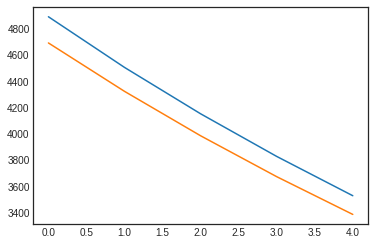

In [ ]:
plt.plot(plot_iter, plot_loss_train, plot_loss_test)
display.clear_output(wait=True)
plt.show()

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_review(t):
    
    categories = {0: "Positive",1:"Negative", 2:"Neutral", 3:"Very Positive", 4:"Very Negative"}
    
  
    tokenized = [tok.text for tok in nlp.tokenizer(t)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    #print(prediction)
    #print(prediction.max())
    #print(categories)
    _, pred = torch.max(prediction, 1) 
    #print(pred.item()) 
    return categories[pred.item()]

In [ ]:
classify_review("never buy this product.")

'Negative'

In [ ]:
from google.colab import files

In [ ]:
uploaded=files.upload()

Saving test_sent.pkl to test_sent.pkl


In [ ]:
f1=open('test_sent.pkl','rb')
tst=pickle.load(f1)
f1.close()

In [ ]:
import random
import numpy as np
np.random.seed(43)

In [ ]:
for i in range(10):
  r_n=random.choice(tst)
  p=classify_review(r_n)
  print(f'{r_n} | sentiment : {p}')

A real clunker . | sentiment : Positive
Immediately . | sentiment : Positive
Enormously likable , partly because it is aware of its own grasp of the absurd . | sentiment : Negative
Tom Green just gives them a bad odor . | sentiment : Negative
The film 's real appeal wo n't be to Clooney fans or adventure buffs , but to moviegoers who enjoy thinking about compelling questions with no easy answers . | sentiment : Negative
Audiences will find no mention of political prisoners or persecutions that might paint the Castro regime in less than saintly tones . | sentiment : Negative
Viewed on its own terms , Treasure Planet is better-than-average family entertainment , but true fans of the Stevenson 's novel will likely prefer Disney 's more faithful 1950 live-action swashbuckling classic . | sentiment : Negative
Dissing a Bond movie is quite like calling a dog stupid , but when it has the temerity to run over two hours , you feel like winding up with a kick . | sentiment : Positive
The tug of 